#### Going to train a few flows on DC2 `r-i` vs `redshift` to show the discreteness and the effect of changing `K` in the neural splines.

In [1]:
import jax.numpy as np
import matplotlib.pyplot as plt
import corner
import pandas as pd

import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, InvSoftplus, StandardScaler, RollingSplineCoupling

In [2]:
# plotting style
plt.style.use('../paper.mplstyle')
twocol = 7.1014
onecol = 3.35

#### Load the DC2 data

In [3]:
data = pd.read_pickle("dc2.pkl")
# select a subset
data = data[:100000]
# print some
data

,redshift,r-i
0,0.987702,0.922920
1,0.442363,0.757561
2,0.963493,0.688784
3,0.316967,0.309786
4,0.979190,0.904192
...,...,...
99995,1.023449,0.253725
99996,0.908725,0.603003
99997,0.229603,0.448530
99998,1.067950,0.192900


#### Plot the data

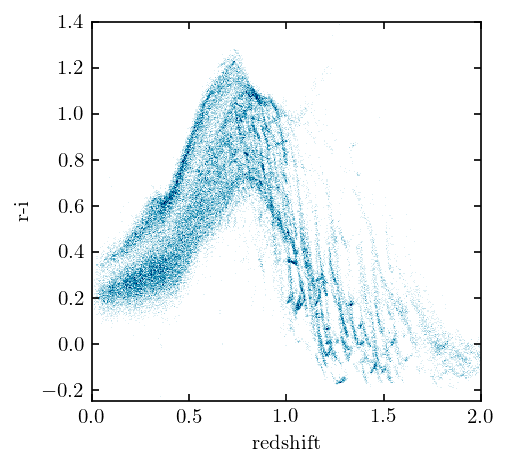

In [17]:
fig, ax = plt.subplots()
ax.hist2d(data['redshift'], data['r-i'], 512, cmap="ocean_r")
ax.set(xlim=(0, 2), ylim=(-0.25, 1.4), 
       xlabel="redshift", ylabel="r-i")
plt.show()

#### I will make two flows: one with low resolution (`K=2`) and one with high resolution (`K=64`)

In [31]:
# set the inverse softplus parameters, 
# to ensure that sampled redshifts are positive
column_idx = 0
sharpness = 10

# calculate the mean and standard deviations of the dimensions
means = data.mean(axis=0).values
stds = data.std(axis=0).values

# set number of layers in the RollingSplineCoupling
# equal to the input dimension
nlayers = data.shape[1]

# construct our bijectors
# by chaining all these layers
bijector_lowres = Chain(
    InvSoftplus(column_idx, sharpness),
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers, K=2),
)
bijector_highres = Chain(
    InvSoftplus(column_idx, sharpness),
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers, K=64),
)

# create the two flows
flow_lowres = Flow(data.columns, bijector_lowres)
flow_highres = Flow(data.columns, bijector_highres)

#### Train the low-res flow

In [32]:
%%time
losses_lowres = flow_lowres.train(data, epochs=200, verbose=True)

Training 200 epochs 
Loss:
0.8419
0.1251
0.0238
-0.0059
-0.0016
-0.0056
-0.0123
-0.0165
-0.0184
-0.0221
-0.0222
-0.0212
-0.0292
-0.0273
-0.0316
-0.0372
-0.0275
-0.0317
-0.0285
-0.0418
-0.0415
CPU times: user 1min 58s, sys: 27.2 s, total: 2min 25s
Wall time: 1min 20s


#### Plot the low-res results

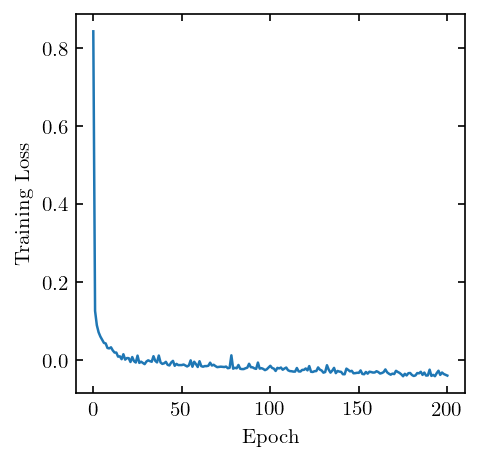

In [33]:
plt.plot(losses_lowres)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

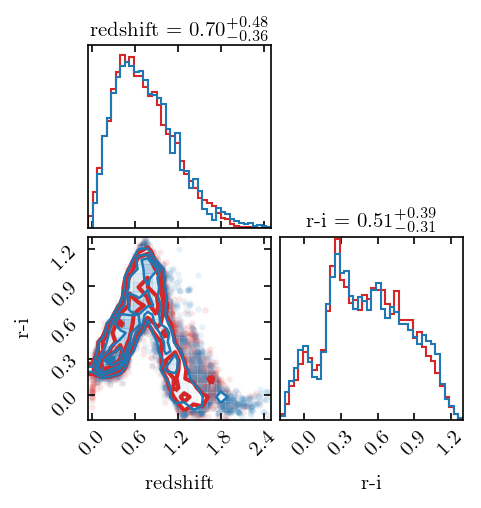

In [34]:
fig = plt.figure()

ranges =  [(-0.05, 2.5), (-0.2, 1.3)]

samples = flow_lowres.sample(10000, seed=0)
corner.corner(samples, fig=fig, color='C3', bins=20, range=ranges, 
              hist_bin_factor=2, data_kwargs={'ms':3}, contour_kwargs={'linewidths':2})

corner.corner(data[:10000], fig=fig, bins=20, range=ranges, 
              hist_bin_factor=2, color='C0', data_kwargs={'ms':3}, show_titles=True)

plt.show()

In [35]:
samples_lowres = flow_lowres.sample(100000, seed=0)

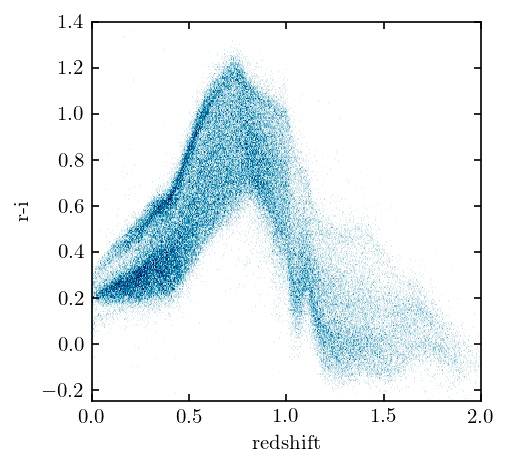

In [36]:
fig, ax = plt.subplots()
ax.hist2d(samples_lowres['redshift'], samples_lowres['r-i'], 512, cmap="ocean_r")
ax.set(xlim=(0, 2), ylim=(-0.25, 1.4), 
       xlabel="redshift", ylabel="r-i")
plt.show()

#### Now train the high-res flow

In [37]:
%%time
losses_highres = flow_highres.train(data, epochs=200, verbose=True)

Training 200 epochs 
Loss:
0.8859
0.1040
-0.1163
-0.1309
-0.1445
-0.1491
-0.1439
-0.1639
-0.1684
-0.1674
-0.1738
-0.1779
-0.1702
-0.1879
-0.1843
-0.1825
-0.1810
-0.1850
-0.1961
-0.1926
-0.1960
CPU times: user 2min 33s, sys: 4min 30s, total: 7min 3s
Wall time: 2min 7s


#### Plot the high-res results

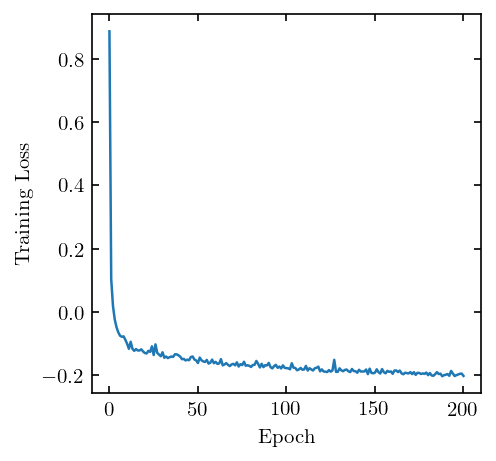

In [38]:
plt.plot(losses_highres)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

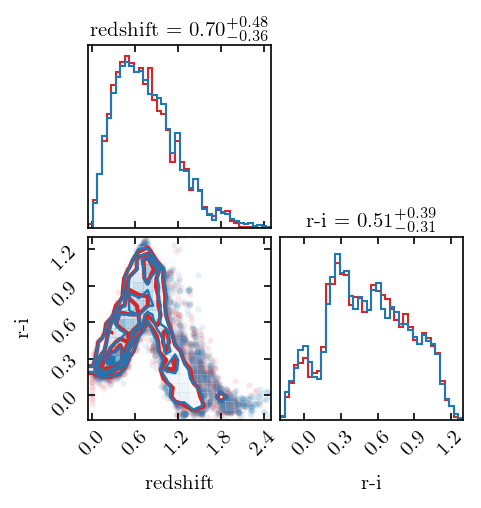

In [39]:
fig = plt.figure()

ranges =  [(-0.05, 2.5), (-0.2, 1.3)]

samples = flow_highres.sample(10000, seed=0)
corner.corner(samples, fig=fig, color='C3', bins=20, range=ranges, 
              hist_bin_factor=2, data_kwargs={'ms':3}, contour_kwargs={'linewidths':2})

corner.corner(data[:10000], fig=fig, bins=20, range=ranges, 
              hist_bin_factor=2, color='C0', data_kwargs={'ms':3}, show_titles=True)

plt.show()

In [40]:
samples_highres = flow_highres.sample(100000, seed=0)

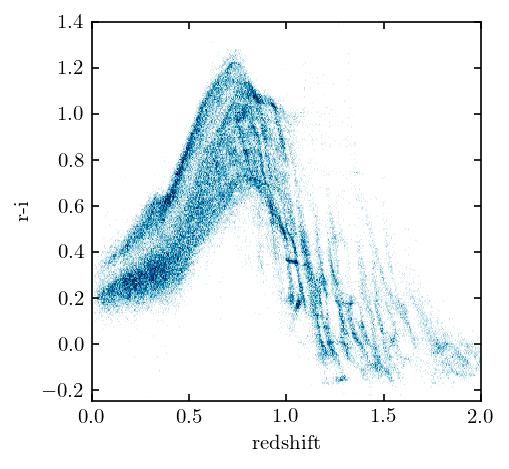

In [41]:
fig, ax = plt.subplots()
ax.hist2d(samples_highres['redshift'], samples_highres['r-i'], 512, cmap="ocean_r")
ax.set(xlim=(0, 2), ylim=(-0.25, 1.4), 
       xlabel="redshift", ylabel="r-i")
plt.show()

#### Now let's combine them all into a single plot for the paper

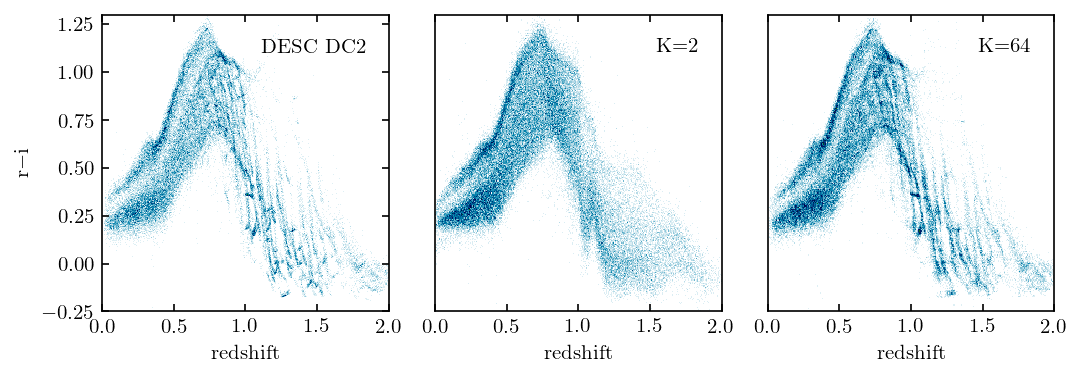

In [84]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(twocol, 0.72*onecol), constrained_layout=True)

ax1.hist2d(data['redshift'], data['r-i'], 512, cmap="ocean_r", rasterized=True)
ax2.hist2d(samples_lowres['redshift'], samples_lowres['r-i'], 512, cmap="ocean_r", rasterized=True)
ax3.hist2d(samples_highres['redshift'], samples_highres['r-i'], 512, cmap="ocean_r", rasterized=True)

ax1.text(0.92, 0.92, "DESC DC2", va='top', ha='right', transform=ax1.transAxes)
ax2.text(0.92, 0.92, "K=2", va='top', ha='right', transform=ax2.transAxes)
ax3.text(0.92, 0.92, "K=64", va='top', ha='right', transform=ax3.transAxes)

for ax in [ax1, ax2, ax3]:
    ax.set(xlim=(0, 2), ylim=(-0.25, 1.3), xlabel="redshift")
ax1.set(ylabel="r$-$i")
ax2.set(yticks=[])
ax3.set(yticks=[])

fig.savefig("spline-resolution.pdf")